In [1]:
import sys
sys.path.append("models/")

from collections import OrderedDict
import glob
import json
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size":12})
import numpy as np
import os
import pandas as pd
import pickle as pkl
import seaborn as sns

import cv2
from sklearn import linear_model
import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms

from dataloader import image_loader

import util_image
from util_model import load_model, my_loss
from dataloader import load_demo
from M1_util_train_test import test
import util_plot
from setup import *

%load_ext autoreload
%autoreload 2

## Model Setup

In [2]:
zoomlevel = 'zoom15'
output_dim = 3
model_run_date = "2208"
sampling='stratified'
normalization = 'minmax'
data_version = '1571'
variable_names = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','avg_tt_to_work','inc_per_capita']
model_save_variable_names = ['totpop','pct25-34','pct35-50','pctsenior',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pctcolgrad','avg_tt_to_work','inc']
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")


In [3]:
demo_cs, demo_np = load_demo(data_dir, norm=normalization)

In [4]:
v1 = 'D'
v2 = 1 
weight, lr, wd = get_hp_from_version_code(v1,v2)

if weight > 100:
    weightt = 1/weight
    weight = 1

else:
    weightt = 1

In [5]:
args = {'weight':weight,
        'weightt':weightt,
        'image_size': 224, 
        'depth': -1,
       'base_channels':64,
       'output_dim':output_dim,
       'num_demo_vars':len(variable_names),
       'demo_norm': normalization,
       'cardinality':1,
       'epochs':200,
       'batch_size':16,
       'base_lr':lr,
       'weight_decay':wd,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[50,100]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':True}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('input_shape', (1, 3, 32, 32)),
    ('output_dim', args['output_dim']),
    ('num_demo_vars', args['num_demo_vars'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('momentum', args['momentum']),
    ('nesterov', args['nesterov']),
    ('milestones', json.loads(args['milestones'])),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('dataset', 'CIFAR10'),
    ('image_size', args['image_size']),
    ('demo_norm', args['demo_norm'])
])

run_config = OrderedDict([
    ('weight', args['weight']),
    ('weightt', args['weightt']),
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

## Load Data

In [6]:
train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], 
                                         run_config['num_workers'], 
                                         data_config['image_size'], data_version=data_version,
                                         sampling=sampling, recalculate_normalize=False)

28278 images in dataset
3142 images in dataset


## Load Model

In [7]:
# Check one model exists for this config
model_path = glob.glob(model_dir+"SAE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(v1)+"_"+str(v2)+"_"+
                model_run_date+"_*.pt")
#
if len(model_path) == 1:
    saved = torch.load(model_path[0])
    print(model_path[0], "loaded.")
else:
    print("Error. More than one model or no model exists.")
    print(model_path)
    print(model_dir+"SAE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(v1)+"_"+str(v2)+"_"+
                model_run_date+"_*.pt")

/dreambig/qingyi/image_chicago/models/SAE_zoom15_18432_D_1_2208_395.pt loaded.


In [8]:
# load model
config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config']['arch'], 'Encoder', config['model_config'])

config['model_config']['input_shape'] = [1,2048,config['model_config']['output_dim'],config['model_config']['output_dim']]

config['model_config']['conv_shape'] = [data_config['image_size']//32,data_config['image_size']//32]
config['model_config']['output_channels'] = 3

decoder = load_model(config['model_config']['arch'], 'Decoder', config['model_config'])

config['encoder'] = encoder
config['decoder'] = decoder

model = load_model('autoencoder','Autoencoder', config)
model.load_state_dict(saved['model_state_dict']);

In [9]:
model = model.to(device)
model.eval();

## Latent Space Interpolation

In [36]:
# dt = "17_31_839100"
# south = "17_31_842100"
# north = "17_31_802300"

dt = "17_31_20702"
south = "17_31_770500"
north = "17_31_804201"

# im1 = np.random.choice(all_test_image_list)
# im2 = np.random.choice(all_test_image_list)

im1 = image_dir+zoomlevel+"/"+dt+"_0.png"
im2 = image_dir+zoomlevel+"/"+south+"_0.png"
im3 = image_dir+zoomlevel+"/"+north+"_0.png"

image_name1 = im1.split("/")[-1].split(".")[0]
image_name2 = im2.split("/")[-1].split(".")[0]
image_name3 = im3.split("/")[-1].split(".")[0]


i1 = util_image.single_image_to_tensor_input(im1, data_config['image_size'])
i2 = util_image.single_image_to_tensor_input(im2, data_config['image_size'])
i3 = util_image.single_image_to_tensor_input(im3, data_config['image_size'])

i1 = i1.to(device)
i2 = i2.to(device)
i3 = i3.to(device)

enc1 = encoder(i1).reshape(1, -1)
enc2 = encoder(i2).reshape(1, -1)
enc3 = encoder(i3).reshape(1, -1)


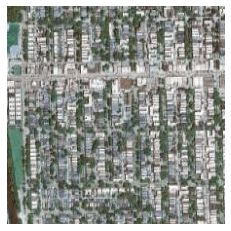

In [37]:
plt.imshow(util_image.center_crop(cv2.imread(im1), (224,224)))
plt.axis("off")
plt.show()

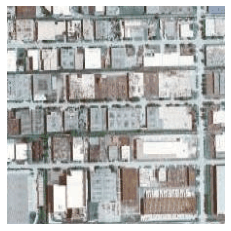

In [38]:
plt.imshow(util_image.center_crop(cv2.imread(im2), (224,224)))
plt.axis("off")
plt.show()

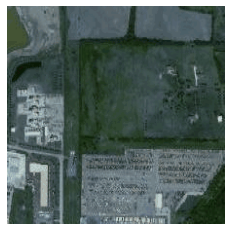

In [39]:
plt.imshow(util_image.center_crop(cv2.imread(im3), (224,224)))
plt.axis("off")
plt.show()

### 1. Latent Space Dimension Reduction

In [11]:
with open(proj_dir+"latent_space/SAE_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                       v1+"_"+str(v2)+"_"+model_run_date+".pkl", "rb") as f: 
    encoder_output = pkl.load(f)
    im = pkl.load(f)
    ct = pkl.load(f)

In [12]:
unique_ct = list(set(ct))
unique_ct.sort()
ct = np.array(ct)
aggregate_embeddings = []
for i in unique_ct:
    aggregate_embeddings.append(np.mean(encoder_output[ct == i], axis=0))
aggregate_embeddings = np.array(aggregate_embeddings)

In [13]:
index1 = unique_ct.index(dt)
index2 = unique_ct.index(south)
index3 = unique_ct.index(north)

agg_enc1 = aggregate_embeddings[index1,:]
agg_enc2 = aggregate_embeddings[index2,:]
agg_enc3 = aggregate_embeddings[index3,:]

In [14]:
enc12 = []
enc13 = []
for alpha in np.linspace(0, 1, 20):
    enc12.append((1-alpha)*agg_enc1+alpha*agg_enc2)
    enc13.append((1-alpha)*agg_enc1+alpha*agg_enc3)

enc12 = np.vstack(enc12)
enc13 = np.vstack(enc13)

In [15]:
# tSNE
from sklearn import manifold
method = manifold.TSNE(n_components=2, init='pca', random_state=1)
# tsne_im = method.fit_transform(encoder_output)
# tsne_ct = method.fit_transform(np.concatenate([aggregate_embeddings, enc12, enc13], axis=0))
tsne_ct = method.fit_transform(aggregate_embeddings)

/home/jtl/anaconda3/envs/dingyi_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jtl/anaconda3/envs/dingyi_env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [16]:
a = tsne_ct

In [17]:
north_idx = unique_ct.index(north)

south_idx = unique_ct.index(south)

dt_idx = unique_ct.index(dt)

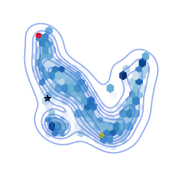

In [18]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
hexagons = ax.hexbin(a[:,0], a[:,1], gridsize=17, mincnt=1, cmap='Blues')
sns.kdeplot(x=a[:,0], y=a[:,1], ax=ax, levels=7, color='royalblue', alpha=0.5)
# ax.plot(tsne12[:,0], tsne12[:,1], c='r')
# ax.plot(tsne13[:,0], tsne13[:,1], c='g')
ax.scatter(a[north_idx,0], a[north_idx,1], c='y',s=20)
ax.scatter(a[dt_idx,0], a[dt_idx,1], c='r',s=20)
ax.scatter(a[south_idx,0], a[south_idx,1], marker='*', c='k',s=40)

plt.axis("off")
plt.show()

fig.savefig(out_dir+"latent_space/SAE_"+zoomlevel+"_"+str(output_dim**2*2048)+"_"+
                           v1+"_"+model_run_date+"_traj.png", bbox_inches='tight')

### PCA 
from sklearn.decomposition import PCA
m = PCA(n_components=2)
m.fit(aggregate_embeddings)

In [ ]:
apca = m.transform(aggregate_embeddings)
fig, ax = plt.subplots(1,1,figsize=(3,3))
hexagons = ax.hexbin(apca[:,0], apca[:,1], gridsize=17, mincnt=1, cmap='Blues')
sns.kdeplot(x=apca[:,0], y=apca[:,1], ax=ax, levels=7, color='royalblue', alpha=0.5)

t1 = m.transform(enc12)
plt.plot(t1[:,0], t1[:,1], c='cornflowerblue')
t2 = m.transform(enc13)
plt.plot(t2[:,0], t2[:,1], c='salmon')

plt.axis("off")
plt.show()

# fig.savefig(out_dir+"image_samples/image_complex/"+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
#                     model_run_date+"_latent_traj_"+
#                     image_name1+"_mix_"+image_name2+"_mix_"+image_name3+".png", 
#                     bbox_inches='tight')

### 2. Image Complex

In [19]:
from mnl import MNL
model_mnl = MNL(n_alts=4, n_features=output_dim**2*2048)
saved = torch.load(out_dir+"sae_a_D_1_220829.pt")
model_mnl.load_state_dict(saved);

In [40]:
sharpen_kernel = np.array([[0, -1, 0],
               [-1, 5,-1],
               [0, -1, 0]])

In [41]:
mult_list = np.arange(0,1.8,0.2)

mult_list

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6])

In [42]:
dec_imgs = []
demos = []
logsums = []
auto_ = []
pt_ = []
active_ = []

for alpha in mult_list:
    row = []
    logsum_row = []
    img_row = []
    auto_row = []
    pt_row = []
    active_row = []
    
    for beta in mult_list:
        enc = enc2 + alpha*(enc1-enc2) + beta*(enc3-enc2)
#         enc = enc1 + alpha*(enc2-enc1) + beta*(enc3-enc1)
        dec, dec_demo = model(x=None, xp=enc)
        enc = enc.cpu()
        
        util = model_mnl(enc)
        util = util.detach().numpy()
        auto_row.append(np.exp(util)[0][1]/np.sum(np.exp(util)))
        pt_row.append(np.exp(util)[0][3]/np.sum(np.exp(util)))
        active_row.append(np.exp(util)[0][0]/np.sum(np.exp(util)))

        util = np.log(np.sum(np.exp(util)))
        logsum_row.append(util)
        
        img = util_image.inverse_transform(dec.detach().cpu())[0].permute(1,2,0).numpy()
        im_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=sharpen_kernel)
        im_sharp = cv2.filter2D(src=im_sharp, ddepth=-1, kernel=sharpen_kernel)
        img_row.append(np.clip(img,0,1))
        
        row.append(dec_demo.detach().cpu().numpy())
        
    demos.append(row)
    logsums.append(logsum_row)
    dec_imgs.append(img_row)
    auto_.append(auto_row)
    pt_.append(pt_row)
    active_.append(active_row)
    
# demos = np.array(demos)


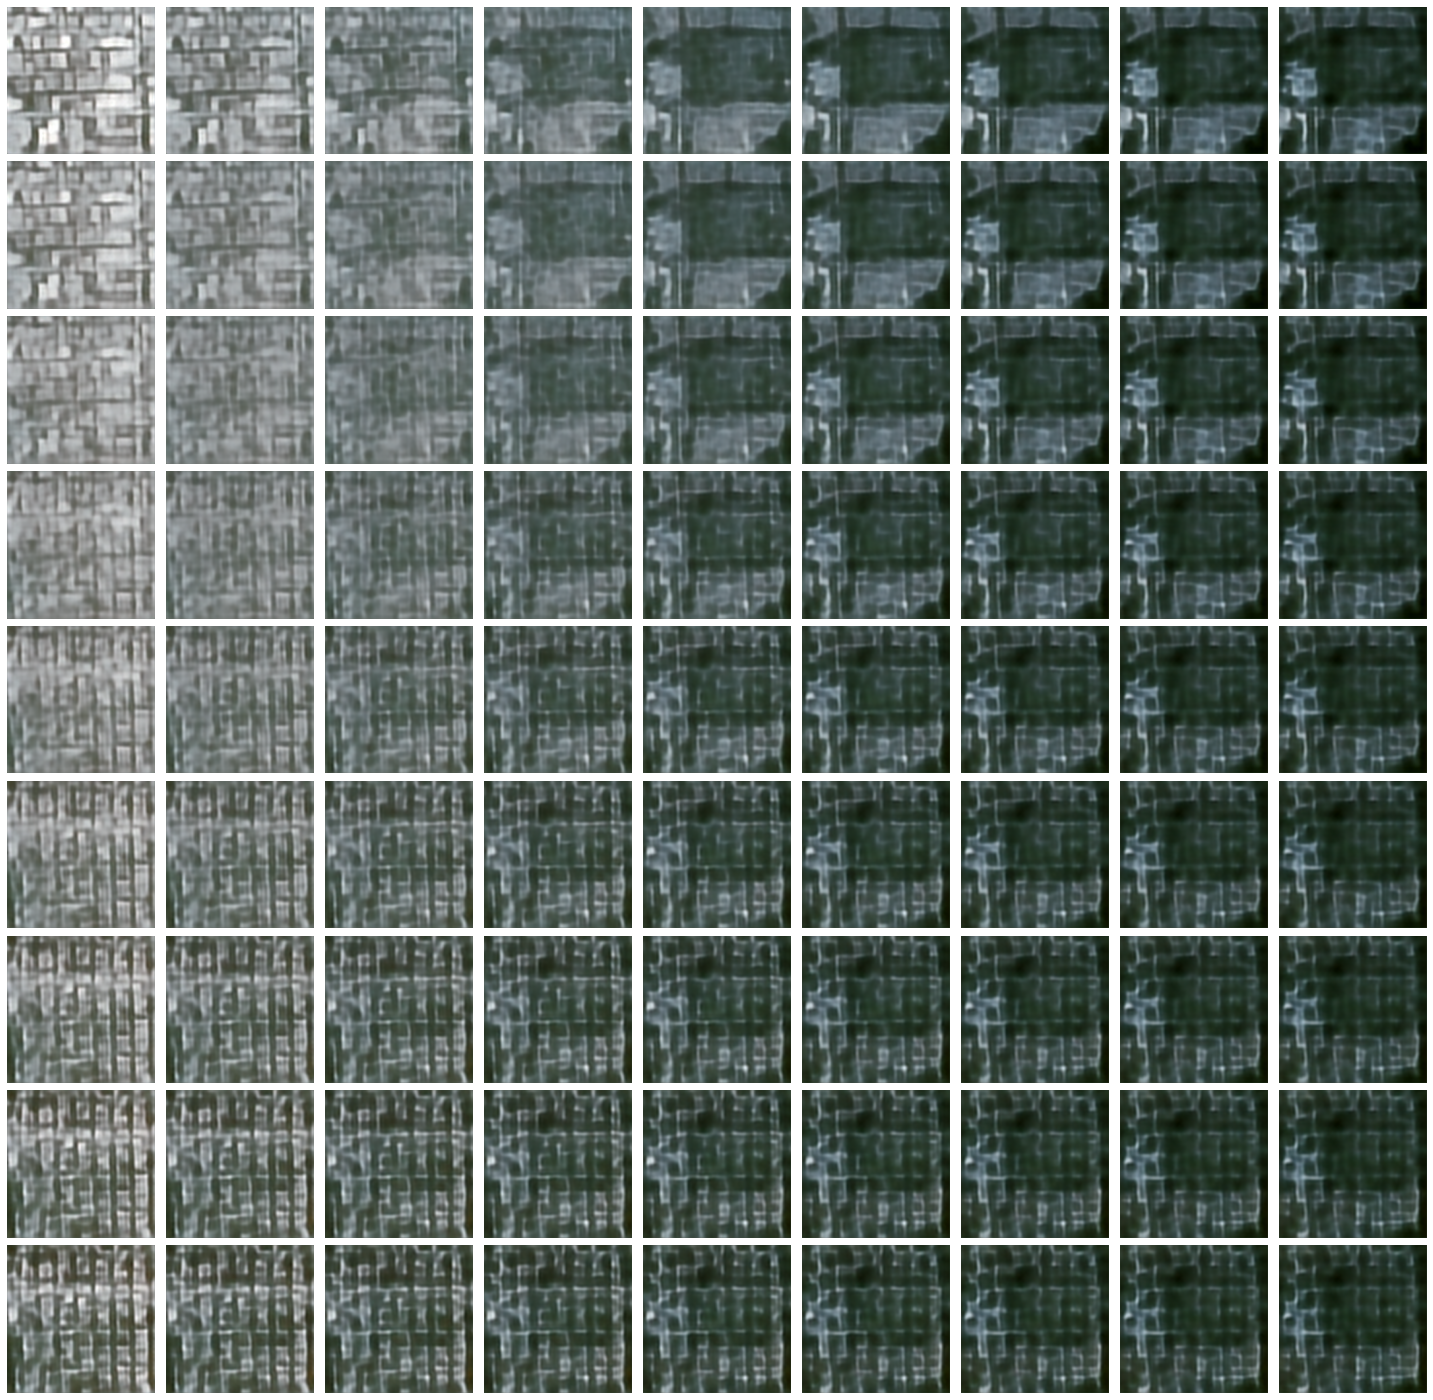

In [43]:
fig, ax = util_plot.plot_images(len(mult_list), len(mult_list), dec_imgs, mag=3)
plt.show()

In [44]:
fig.savefig(out_dir+"image_samples/image_complex/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+v1+"_"+str(v2)+"_"+
                    model_run_date+"_interpolation_"+
                    image_name1+"_mix_"+image_name2+"_mix_"+image_name3+"_"+str(len(mult_list))+".png", 
                    bbox_inches='tight')


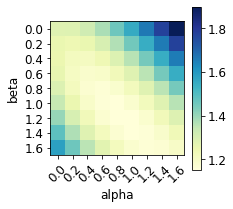

In [32]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
plt.imshow(np.array(logsums),cmap="YlGnBu")
ax.set_xticks(np.arange(len(mult_list)))
ax.set_xticklabels(["{:.1f}".format(a) for a in mult_list],rotation=45)
ax.set_yticks(np.arange(len(mult_list)))
ax.set_yticklabels(["{:.1f}".format(a) for a in mult_list])
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
plt.colorbar()
plt.show()
fig.savefig(out_dir+"image_samples/image_complex/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_welfare_complex_"+
                    image_name1+"_mix_"+image_name2+"_mix_"+image_name3+".png", 
                    bbox_inches='tight')

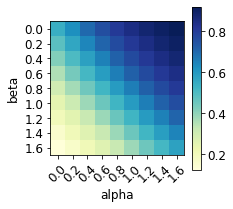

In [33]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
plt.imshow(np.array(auto_),cmap="YlGnBu")
ax.set_xticks(np.arange(len(mult_list)))
ax.set_xticklabels(["{:.1f}".format(a) for a in mult_list],rotation=45)
ax.set_yticks(np.arange(len(mult_list)))
ax.set_yticklabels(["{:.1f}".format(a) for a in mult_list])
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
plt.colorbar()
plt.show()
fig.savefig(out_dir+"image_samples/image_complex/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_auto_complex_"+
                    image_name1+"_mix_"+image_name2+"_mix_"+image_name3+".png", 
                    bbox_inches='tight')

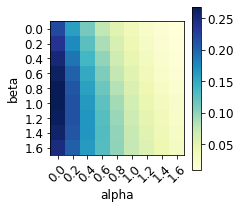

In [34]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
plt.imshow(np.array(pt_),cmap="YlGnBu")
ax.set_xticks(np.arange(len(mult_list)))
ax.set_xticklabels(["{:.1f}".format(a) for a in mult_list],rotation=45)
ax.set_yticks(np.arange(len(mult_list)))
ax.set_yticklabels(["{:.1f}".format(a) for a in mult_list])
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
plt.colorbar()
plt.show()
fig.savefig(out_dir+"image_samples/image_complex/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_pt_complex_"+
                    image_name1+"_mix_"+image_name2+"_mix_"+image_name3+".png", 
                    bbox_inches='tight')

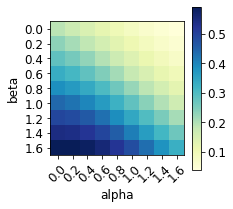

In [35]:
fig, ax = plt.subplots(1,1, figsize=(3,3))
plt.imshow(np.array(active_),cmap="YlGnBu")
ax.set_xticks(np.arange(len(mult_list)))
ax.set_xticklabels(["{:.1f}".format(a) for a in mult_list],rotation=45)
ax.set_yticks(np.arange(len(mult_list)))
ax.set_yticklabels(["{:.1f}".format(a) for a in mult_list])
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
plt.colorbar()
plt.show()
fig.savefig(out_dir+"image_samples/image_complex/"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_active_complex_"+
                    image_name1+"_mix_"+image_name2+"_mix_"+image_name3+".png", 
                    bbox_inches='tight')

## Latent Space Directional Move

In [35]:
def get_image_info(ct, k):
    im = image_dir+zoomlevel+"/"+ct+"_"+str(k)+".png"
    image_name = im.split("/")[-1].split(".")[0]
    i = util_image.single_image_to_tensor_input(im, data_config['image_size'])
    i = i.to(device)
    enc = encoder(i)
    
    return im, image_name, i, enc

In [36]:
sharpen_kernel = np.array([[0, -1, 0],
               [-1, 5,-1],
               [0, -1, 0]])

In [37]:
c1 = "17_31_842100"
c2 = "17_31_802300"
# c3 = "17_31_842100"

im1, image_name1, i1, enc1 = get_image_info(c1, 0)
im2, image_name2, i2, enc2 = get_image_info(c2, 0)
# im3, image_name3, i3, enc3 = get_image_info(c3, )

In [38]:
mix1 = enc1
mix2 = enc2
# mix3 = enc3
image_name = image_name1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

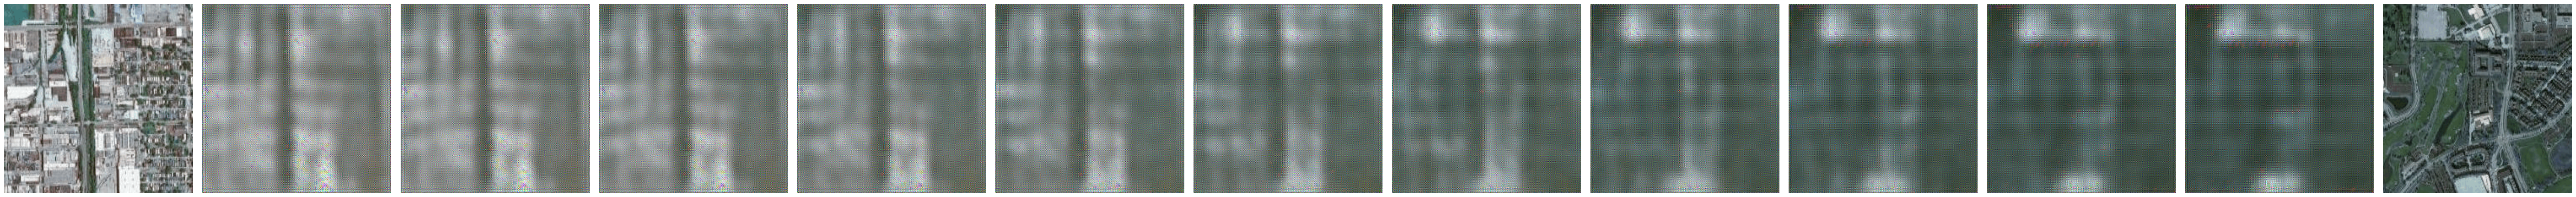

In [40]:

dec_demo = []
dec_imgs = [util_image.center_crop(np.array(cv2.imread(im1)), (224,224))]
for alpha in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
    enc = mix1 * (1-alpha) + alpha * mix2
    dec, dd = model(x=None, xp=enc)
    dec_demo.append(dd.detach().cpu().numpy().flatten())
    im = util_image.inverse_transform(dec.detach().cpu())[0].permute(1,2,0).numpy()
    im_sharp = cv2.filter2D(src=im, ddepth=-1, kernel=sharpen_kernel)
    im_sharp = cv2.filter2D(src=im_sharp, ddepth=-1, kernel=sharpen_kernel)

    dec_imgs.append(im_sharp)
#     dec_imgs.append(im)

#     enc = mix1 * (1-alpha) + alpha * mix3
#     dec, _ = model(x=None, xp=enc)
#     dec_imgs.append(util_image.inverse_transform(dec.detach().cpu())[0].permute(1,2,0))
dec_imgs.append(util_image.center_crop(np.array(cv2.imread(im2)), (224,224)))

fig, ax = util_plot.plot_images(1, 13, dec_imgs, mag=10);
# fig.savefig(out_dir+"image_samples/interpolation/SAE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
#                     model_run_date+"_interpolation_"+
#                     image_name1+"_mix_"+image_name2+".png", 
#                     bbox_inches='tight')

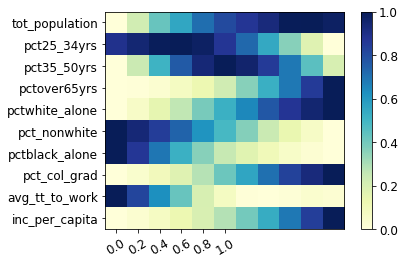

In [47]:
demos = np.squeeze(np.array(dec_demo))
demos_norm = (demos-demos.min(axis=0))/(demos.max(axis=0)-demos.min(axis=0))
demos_norm = demos_norm.T

fig, ax = plt.subplots()
im = ax.imshow(demos_norm, cmap='YlGnBu')
ax.set_xticks(np.arange(6))
ax.set_xticklabels(np.linspace(0,1,6).round(1), rotation=30)
ax.set_yticks(np.arange(len(variable_names)))
ax.set_yticklabels(variable_names)
plt.colorbar(im);


In [84]:
fig.savefig(out_dir+"image_samples/interpolation/"+model_type+"_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+
                    model_run_date+"_interpolation_"+
                    image_name1+"_mix_"+image_name2+"_demo.png", 
                    bbox_inches='tight')